<h1>Capacitor coupler</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.constants import e, hbar

from two_coupled_qubits import ChargeQubit

In [2]:
q1 = ChargeQubit(e_c=0.23084, e_j=16.34, levels=1, n_g=0)
q2 = ChargeQubit(e_c=0.26084, e_j=16.34, levels=1, n_g=0)

In [3]:
# Parameters
c_g = 19.46

# Free Hamiltonian
h0 = tensor(q1.h, q2.h)

# Interacting Hamiltonian
hint = 4 * e**2 * (c_g * 1e-15) / ((q1.c_s * 1e-15) * (q2.c_s * 1e-15)) / hbar * 1e-9  * tensor(q1.number[1], q2.number[1])
g = 0.5 * np.sqrt(q1.w * q2.w) * (c_g * 1e-15)/(np.sqrt(c_g * 1e-15 + q1.c_s * 1e-15)*np.sqrt(c_g * 1e-15 + q2.c_s * 1e-15))

# Total Hamiltonian
h = h0 + hint

In [4]:
# Eigenvectors
_, eigenvectors_q1 = q1.h.eigenstates()
_, eigenvectors_q2 = q2.h.eigenstates()

# States
psi = np.empty((q1.dim, q2.dim), dtype=Qobj)

for i in range(q1.dim):
    for j in range(q2.dim):
        psi[i,j] = tensor(eigenvectors_q1[i], eigenvectors_q2[j])

# Time
t_list = np.linspace(0, np.pi/(2*g), 1000)

In [5]:
# Master Equation
result = mesolve(H=h, rho0=psi[1,0], tlist=t_list, c_ops=[], e_ops=[], args={})

In [6]:
# Expected value
prob = np.empty((q1.dim, q2.dim), dtype=Qobj)

for i in range(q1.dim):
    for j in range(q2.dim):
        prob[i,j] = expect(psi[i,j]*psi[i,j].dag(), result.states)

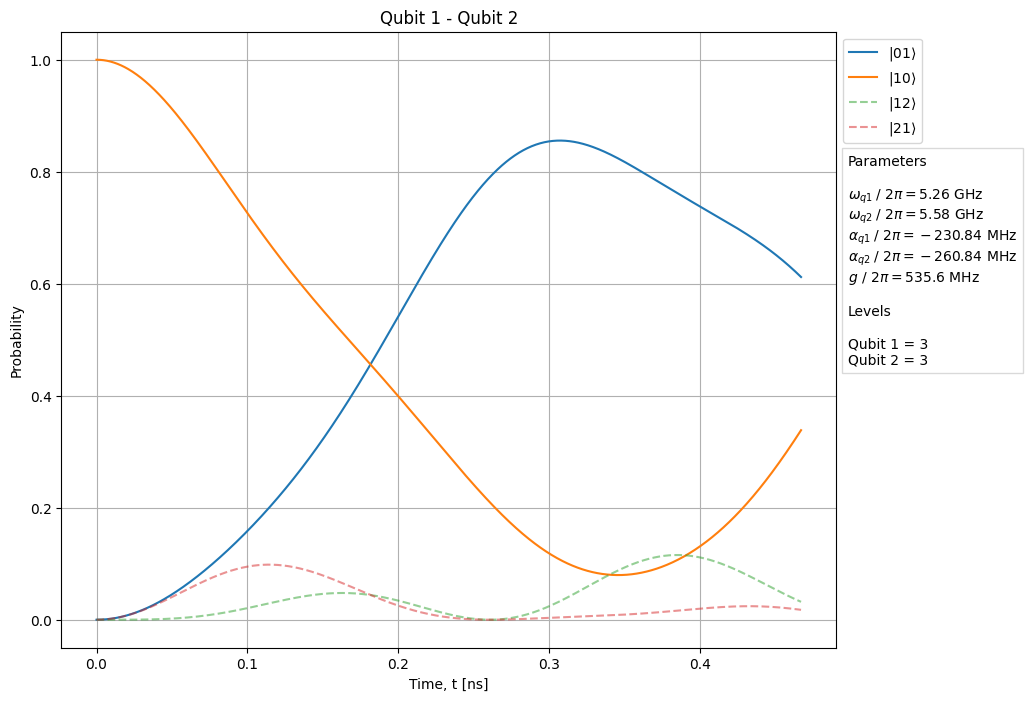

In [7]:
# Parameters
wq1 = round(q1.w / (2 * np.pi), 2)
wq2 = round(q2.w / (2 * np.pi), 2)
alpha1 = round(q1.e_c * 1e3,2)
alpha2 = round(q2.e_c * 1e3,2)

# Plot
fig = plt.figure(figsize=(10,8))

for i in range(q1.dim):
    for j in range(q2.dim):
        if np.max(prob[i,j]) > 0.01:
            if (i,j) == (1,0) or (i,j) == (0,1):
                plt.plot(t_list, prob[i,j], label=f"$|{i}{j}\\rangle$")
                continue
            plt.plot(t_list, prob[i,j], label=f"$|{i}{j}\\rangle$", linestyle="--", alpha=0.5)

plt.ylabel("Probability")
plt.xlabel("Time, t [ns]")
plt.title("Qubit 1 - Qubit 2")
plt.legend(bbox_to_anchor=(1.00, 1.00), loc='upper left')

text = f"""Parameters

$\\omega_{{q1\,\,}}/\,\,2\\pi = ${wq1} GHz
$\\omega_{{q2\,\,}}/\,\,2\\pi = ${wq2} GHz
$\\alpha_{{q1\,\,}}/\,\,2\\pi = - ${alpha1} MHz
$\\alpha_{{q2\,\,}}/\,\,2\\pi = - ${alpha2} MHz
$g\,\,/\,\,2\\pi = ${round(g / (2 * np.pi) * 1e3, 2)} MHz

Levels

Qubit 1 = {q1.dim}
Qubit 2 = {q2.dim}"""

plt.text(1.015, 0.46, text, fontsize=10, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', linewidth=1, alpha=0.15))

plt.grid()
plt.show()